In [ ]:
import pandas as pd
from pathlib import Path

ACTIVITY = 'activity'
DEVICE = 'device'
START_TIME = 'start_time'
END_TIME = 'end_time'

TIME = 'time'
VALUE = 'value'
NAME = 'name'


def load_ordoneza_dataset(data_dir: str):
    data_dir = Path(data_dir)

    # ----------------- 处理活动数据 -----------------
    df_act = pd.read_csv(
        data_dir / 'OrdonezA_ADLs.txt',
        delimiter='\t+',
        skiprows=[0, 1],
        names=[START_TIME, END_TIME, ACTIVITY],
        engine='python'
    )
    
    # 转换时间格式
    df_act[START_TIME] = pd.to_datetime(df_act[START_TIME])
    df_act[END_TIME] = pd.to_datetime(df_act[END_TIME])

    # mask = (df_act[START_TIME] > df_act[END_TIME])
    # df_act.loc[mask, [START_TIME, END_TIME]] = df_act.loc[mask, [END_TIME, START_TIME]].values

    # Manually replace 3 rows where START_TIME > END_TIME in the activity files
    # 72 "2011-12-01 19:28:51  2011-12-01 16:29:59  Toileting"
    # to "2011-12-01 19:28:51  2011-19-01 16:29:59  Toileting"

    # 81 "2011-12-02 12:20:41  2011-12-01 10:20:59  Grooming"
    # to "2011-12-02 12:20:41  2011-12-01 12:20:59  Grooming"

    # 83 "2011-12-02 12:27:47  2011-12-01 11:35:49  Breakfast"
    # to "2011-12-02 12:27:47  2011-12-01 12:35:49  Breakfast"
    df_act.iat[69, 1] = pd.Timestamp('2011-12-01 19:29:59')
    df_act.iat[78, 1] = pd.Timestamp('2011-12-02 12:20:59')
    df_act.iat[80, 1] = pd.Timestamp('2011-12-02 12:35:49')

    # print(df_act[69:81])

    # ----------------- 处理设备数据 -----------------
    # 加载传感器数据
    df_sen = pd.read_csv(
        data_dir / 'OrdonezA_Sensors.txt',
        delimiter='\t+',
        skiprows=[0, 1],
        names=[START_TIME, END_TIME, 'location', 'type', 'place'],
        engine='python'
    )
    
    # 生成唯一设备名称
    df_sen[DEVICE] = df_sen['place'] + '_' + df_sen['location'] + '_' + df_sen['type']
    
    # 多了个空格
    df_sen[START_TIME] = df_sen[START_TIME].apply(lambda x: x.strip())
    df_sen[END_TIME] = df_sen[END_TIME].apply(lambda x: x.strip())
            
    df_sen[START_TIME] = pd.to_datetime(df_sen[START_TIME])
    df_sen[END_TIME] = pd.to_datetime(df_sen[END_TIME])
    
    # 生成设备区域映射表
    device_areas = df_sen[['place', 'location', 'type', DEVICE]].drop_duplicates()
    
    df_start = df_sen.copy().drop(columns=END_TIME)
    df_end = df_sen.copy().drop(columns=START_TIME)

    df_start[VALUE] = True
    df_end[VALUE] = False

    df_start.rename(columns={START_TIME: TIME}, inplace=True)
    df_end.rename(columns={END_TIME: TIME}, inplace=True)

    df_events = pd.concat([df_end, df_start]).sort_values(TIME) \
        .reset_index(drop=True)

    return {
        'activities': df_act,
        'devices': df_events,
        'device_areas': device_areas,
        'activity_list': df_act[ACTIVITY].unique().tolist(),
        'device_list': df_events[DEVICE].unique().tolist()
    }

if __name__ == "__main__":
    dataset = load_ordoneza_dataset(Path("../dataset/UCI_ADL_Binary"))
    
    print("Activities:")
    print(dataset['activities'].head())
    
    print("\nDevice Events:")
    print(dataset['devices'].head())
    
    print("\nDevice Areas Mapping:")
    print(dataset['device_areas'].head())


Activities:
           start_time            end_time   activity
0 2011-11-28 02:27:59 2011-11-28 10:18:11   Sleeping
1 2011-11-28 10:21:24 2011-11-28 10:23:36  Toileting
2 2011-11-28 10:25:44 2011-11-28 10:33:00  Showering
3 2011-11-28 10:34:23 2011-11-28 10:43:00  Breakfast
4 2011-11-28 10:49:48 2011-11-28 10:51:13   Grooming

Device Events:
                 time location      type     place                     device  \
0 2011-11-28 02:27:59      Bed  Pressure   Bedroom       Bedroom_Bed_Pressure   
1 2011-11-28 10:18:11      Bed  Pressure   Bedroom       Bedroom_Bed_Pressure   
2 2011-11-28 10:21:24  Cabinet  Magnetic  Bathroom  Bathroom_Cabinet_Magnetic   
3 2011-11-28 10:21:31  Cabinet  Magnetic  Bathroom  Bathroom_Cabinet_Magnetic   
4 2011-11-28 10:21:44    Basin       PIR  Bathroom         Bathroom_Basin_PIR   

   value  
0   True  
1  False  
2   True  
3  False  
4   True  

Device Areas Mapping:
      place location      type                     device
0   Bedroom      Bed

In [4]:
from utils import correct_activities
# 修正活动数据
dataset['activities'], correction_act = correct_activities(dataset['activities'], retain_corrections=True)
print(correction_act)

[(            start_time            end_time       activity
64 2011-12-01 16:26:35 2011-12-01 16:27:04      Toileting
65 2011-12-01 16:27:03 2011-12-01 16:46:40  Spare_Time/TV,                start_time            end_time       activity
0 2011-12-01 16:26:35.000 2011-12-01 16:27:03      Toileting
1 2011-12-01 16:27:03.001 2011-12-01 16:46:40  Spare_Time/TV), (            start_time            end_time       activity
98 2011-12-03 13:29:00 2011-12-03 13:29:59       Grooming
99 2011-12-03 13:29:48 2011-12-03 14:01:20  Spare_Time/TV,                start_time            end_time       activity
0 2011-12-03 13:29:00.000 2011-12-03 13:29:48       Grooming
1 2011-12-03 13:29:48.001 2011-12-03 14:01:20  Spare_Time/TV)]


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime

In [6]:
# 转换时间列为 datetime 格式
dataset['activities']['start_time'] = pd.to_datetime(dataset['activities']['start_time'])
dataset['activities']['end_time'] = pd.to_datetime(dataset['activities']['end_time'])
dataset['devices']['time'] = pd.to_datetime(dataset['devices']['time'])

Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to ge

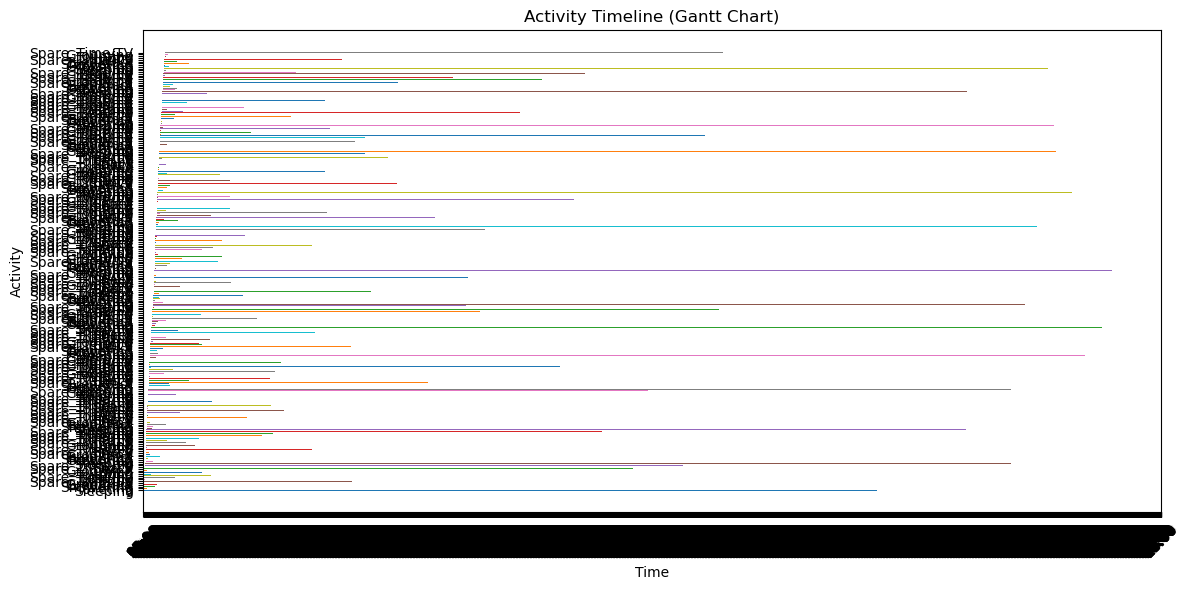

In [11]:
# 可视化 1：活动时间线（甘特图）
def plot_activity_timeline(activities_df):
    plt.figure(figsize=(12, 6))
    
    # 为每个活动分配一个 y 轴位置
    activities_df['y_pos'] = range(len(activities_df))
    
    # 绘制甘特图
    for idx, row in activities_df.iterrows():
        start = row['start_time']
        duration = (row['end_time'] - row['start_time']).total_seconds() / 60  # 持续时间（分钟）
        plt.barh(row['y_pos'], duration, left=mdates.date2num(start), height=0.5, label=row['activity'] if idx == 0 else "")
    
    # 设置 y 轴标签
    plt.yticks(activities_df['y_pos'], activities_df['activity'])
    
    # 设置 x 轴为时间格式
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.xlabel('Time')
    plt.ylabel('Activity')
    plt.title('Activity Timeline (Gantt Chart)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('activity_timeline.png')
    plt.show()
    
plot_activity_timeline(dataset['activities'])

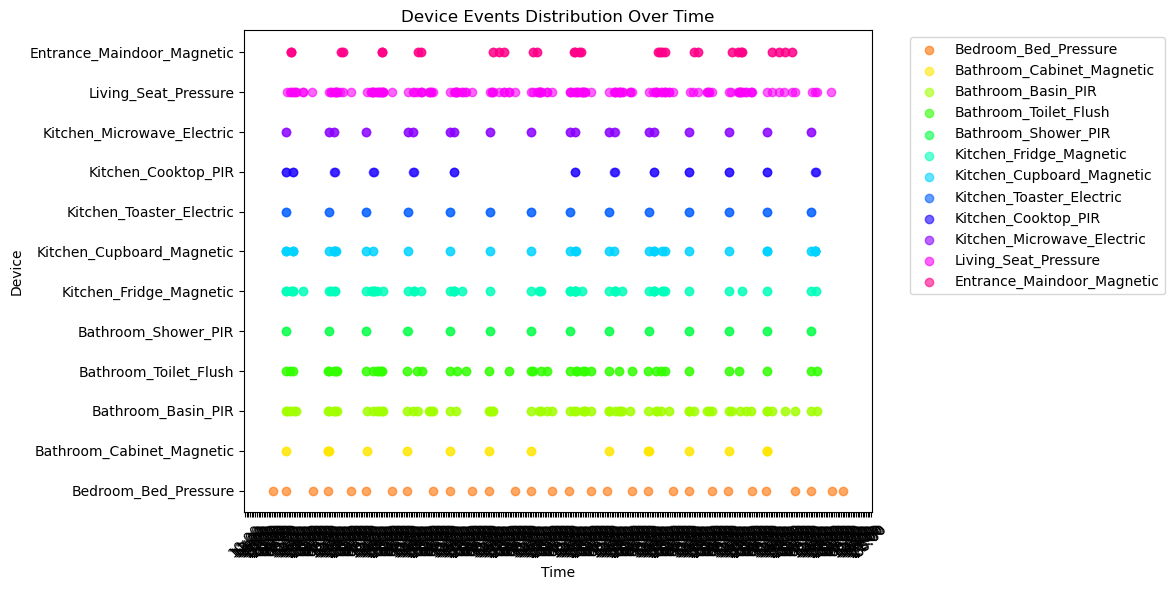

In [14]:
# 可视化 2：设备事件分布（时间轴上的散点图）
def plot_device_events(devices_df):
    plt.figure(figsize=(12, 6))
    
    # 为每个设备分配一个颜色
    devices = devices_df['device'].unique()
    colors = sns.color_palette("hsv", len(devices))
    device_color_map = dict(zip(devices, colors))
    
    # 绘制散点图
    for device in devices:
        device_data = devices_df[devices_df['device'] == device]
        plt.scatter(device_data['time'], [device] * len(device_data), 
                    color=device_color_map[device], label=device, alpha=0.6)
    
    # 设置 x 轴为时间格式
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.xlabel('Time')
    plt.ylabel('Device')
    plt.title('Device Events Distribution Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('device_events_distribution.png')
    plt.show()

plot_device_events(dataset['devices'])

Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15642 ticks ([15306.125, ..., 15957.833333333334]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to ge

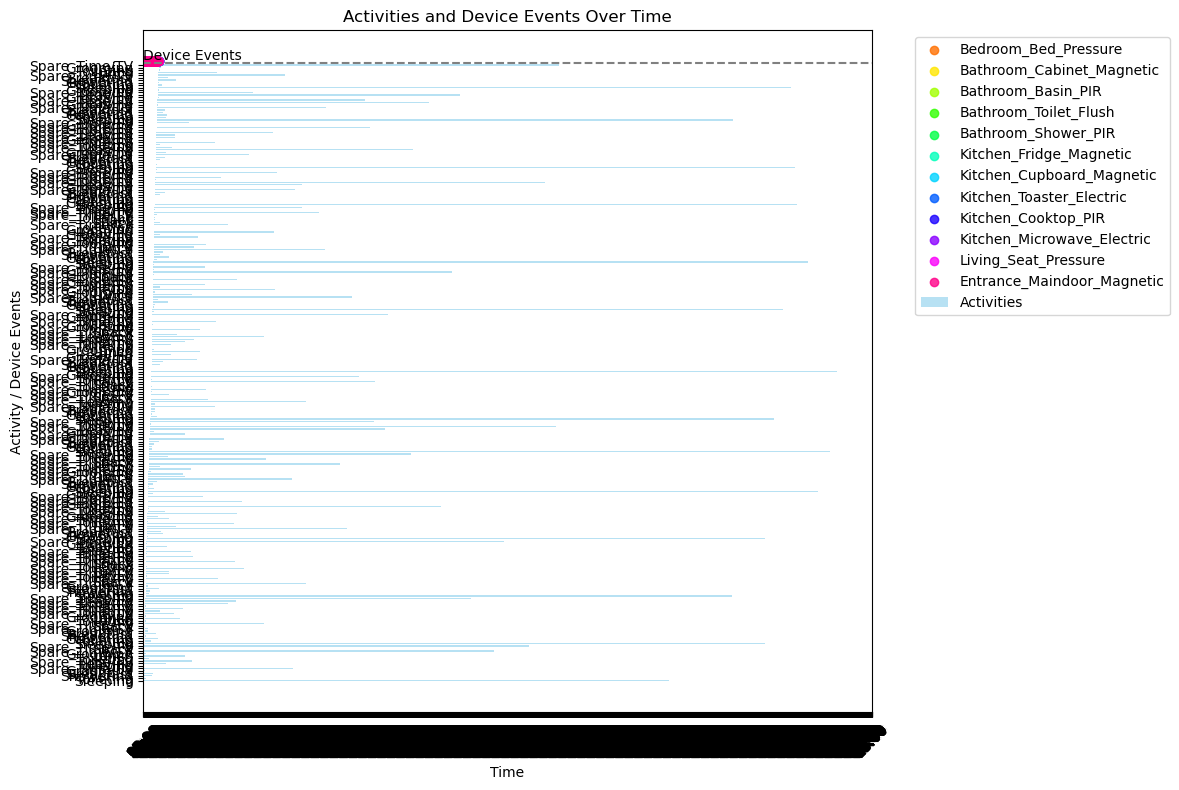

In [15]:
def plot_activities_and_devices(activities_df, devices_df):
    plt.figure(figsize=(12, 8))
    
    # 绘制活动时间线
    activities_df['y_pos'] = range(len(activities_df))
    for idx, row in activities_df.iterrows():
        start = row['start_time']
        duration = (row['end_time'] - row['start_time']).total_seconds() / 60  # 持续时间（分钟）
        plt.barh(row['y_pos'], duration, left=mdates.date2num(start), height=0.5, 
                 color='skyblue', alpha=0.6, label='Activities' if idx == 0 else "")
    
    # 绘制设备事件（在上方叠加）
    devices = devices_df['device'].unique()
    colors = sns.color_palette("hsv", len(devices))
    device_color_map = dict(zip(devices, colors))
    for device in devices:
        device_data = devices_df[devices_df['device'] == device]
        plt.scatter(device_data['time'], [len(activities_df) + 0.5] * len(device_data), 
                    color=device_color_map[device], label=device, alpha=0.8)
    
    # 设置 y 轴标签
    plt.yticks(activities_df['y_pos'], activities_df['activity'])
    plt.axhline(y=len(activities_df), color='gray', linestyle='--')
    plt.text(activities_df['start_time'].min(), len(activities_df) + 1, 'Device Events', fontsize=10)
    
    # 设置 x 轴为时间格式
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.xlabel('Time')
    plt.ylabel('Activity / Device Events')
    plt.title('Activities and Device Events Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('activities_and_devices.png')
    plt.show()
plot_activities_and_devices(dataset['activities'], dataset['devices'])

C:\Users\leave\AppData\Local\Temp\ipykernel_27420\4102601320.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=device_counts.values, y=device_counts.index, palette='viridis')
C:\Users\leave\AppData\Local\Temp\ipykernel_27420\4102601320.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=place_counts.values, y=place_counts.index, palette='magma')


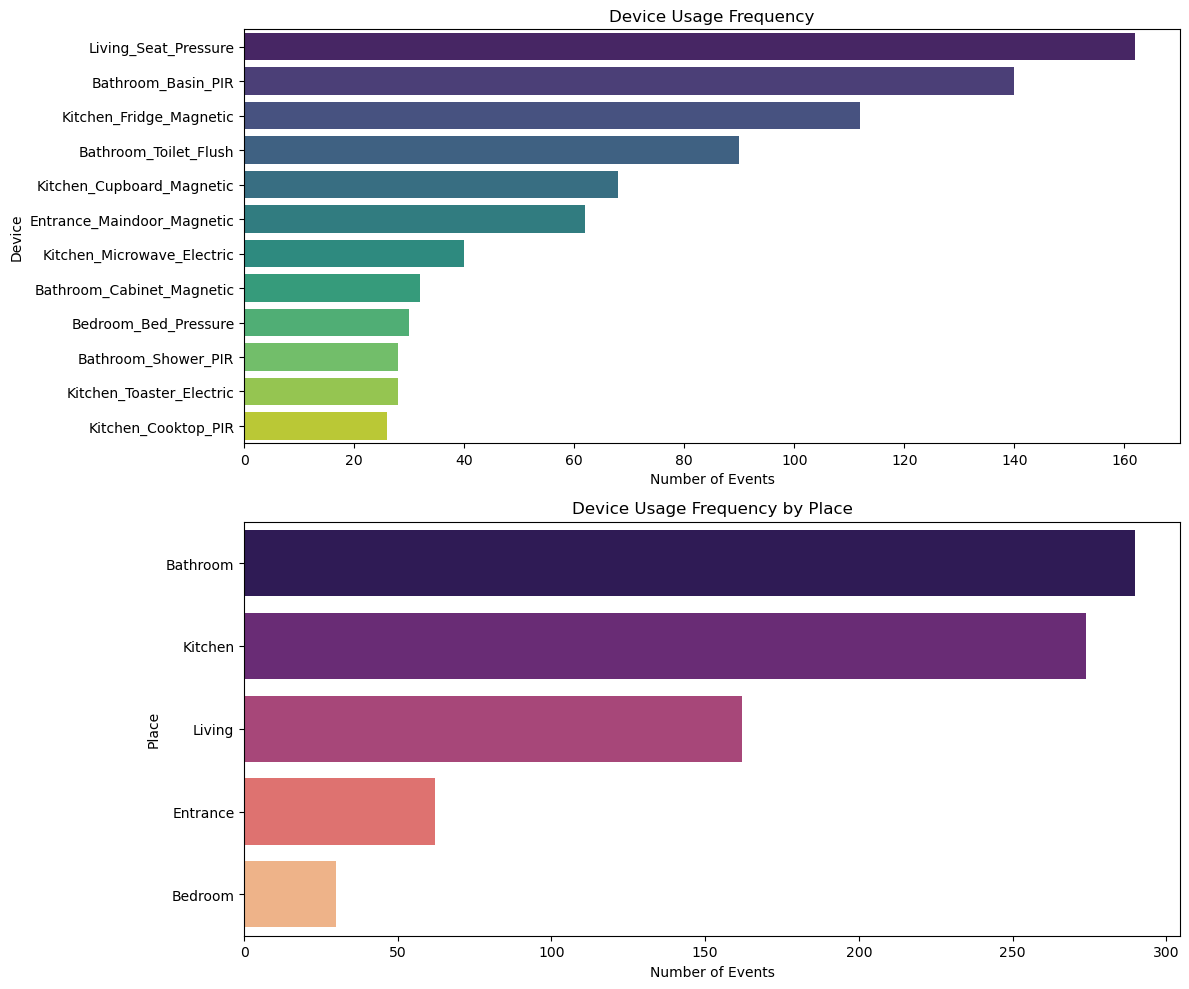

In [16]:
def plot_device_usage_stats(devices_df):
    plt.figure(figsize=(12, 10))
    
    # 按设备统计使用次数
    plt.subplot(2, 1, 1)
    device_counts = devices_df['device'].value_counts()
    sns.barplot(x=device_counts.values, y=device_counts.index, palette='viridis')
    plt.xlabel('Number of Events')
    plt.ylabel('Device')
    plt.title('Device Usage Frequency')
    
    # 按地点（place）统计使用次数
    plt.subplot(2, 1, 2)
    place_counts = devices_df['place'].value_counts()
    sns.barplot(x=place_counts.values, y=place_counts.index, palette='magma')
    plt.xlabel('Number of Events')
    plt.ylabel('Place')
    plt.title('Device Usage Frequency by Place')
    
    plt.tight_layout()
    plt.savefig('device_usage_stats.png')
    plt.show()
plot_device_usage_stats(dataset['devices'])

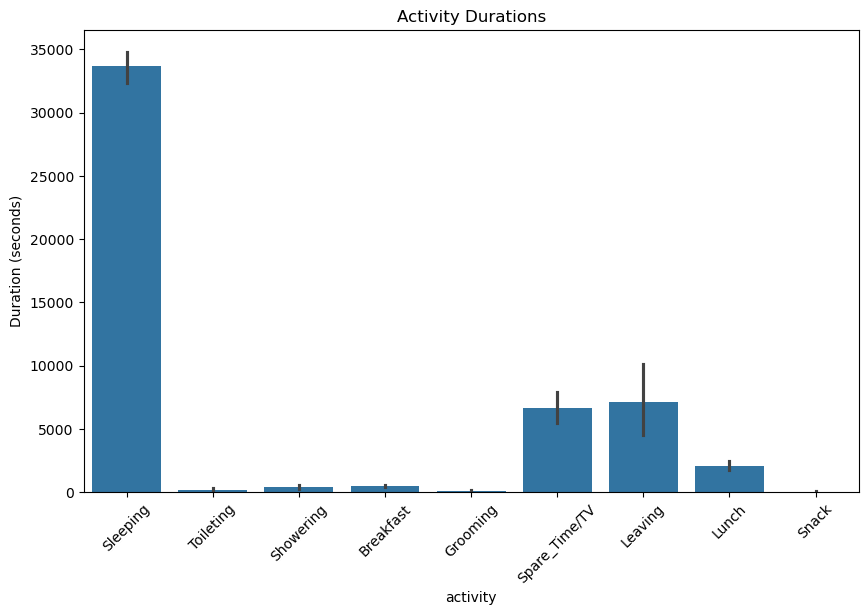

In [6]:
activities = dataset['activities'].copy() 
activities['start_time'] = pd.to_datetime(activities['start_time'])
activities['end_time'] = pd.to_datetime(activities['end_time'])
activities['duration'] = activities['end_time'] - activities['start_time']
activities['duration_seconds'] = activities['duration'].dt.total_seconds()

plt.figure(figsize=(10, 6))
sns.barplot(x='activity', y='duration_seconds', data=activities)
plt.title('Activity Durations')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=45)
plt.show()

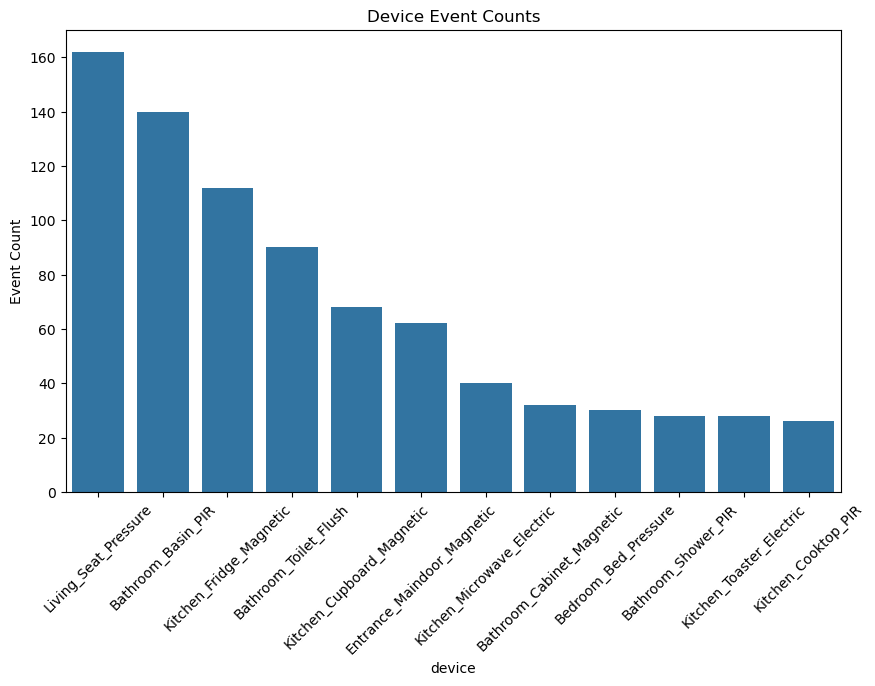

In [7]:
devices = dataset['devices'].copy()
device_event_counts = devices['device'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=device_event_counts.index, y=device_event_counts.values)
plt.title('Device Event Counts')
plt.ylabel('Event Count')
plt.xticks(rotation=45)
plt.show()

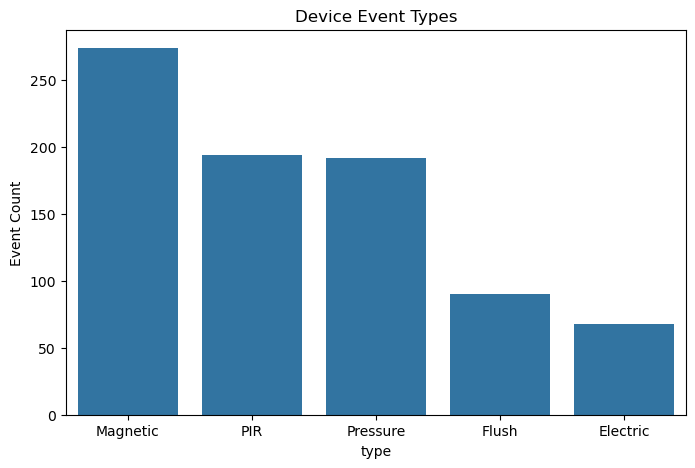

In [8]:
device_type_counts = devices['type'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=device_type_counts.index, y=device_type_counts.values)
plt.title('Device Event Types')
plt.ylabel('Event Count')
plt.show()

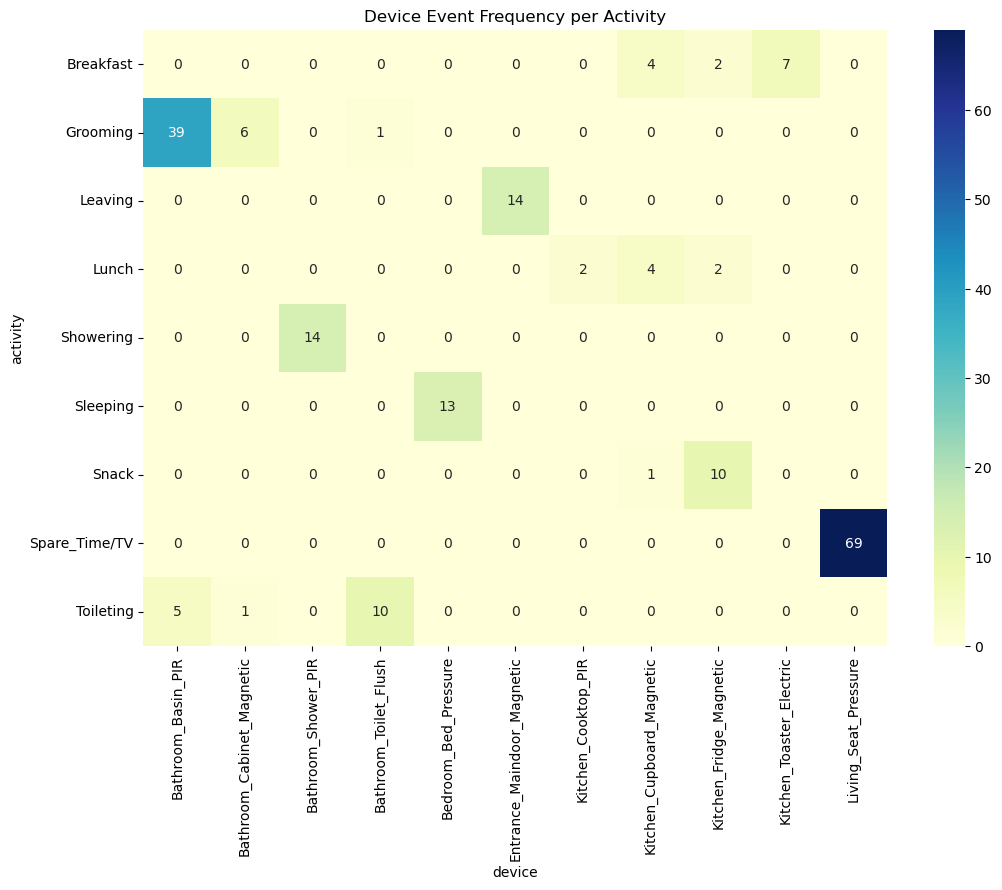

In [9]:
devices['time'] = pd.to_datetime(devices['time'])
merged_data = pd.merge_asof(devices.sort_values('time'), activities.sort_values('start_time'), left_on='time', right_on='start_time', direction='forward')
merged_data = merged_data[(merged_data['time'] >= merged_data['start_time']) & (merged_data['time'] <= merged_data['end_time'])]
activity_device_counts = merged_data.groupby(['activity', 'device']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(activity_device_counts, annot=True, cmap='YlGnBu')
plt.title('Device Event Frequency per Activity')
plt.show()

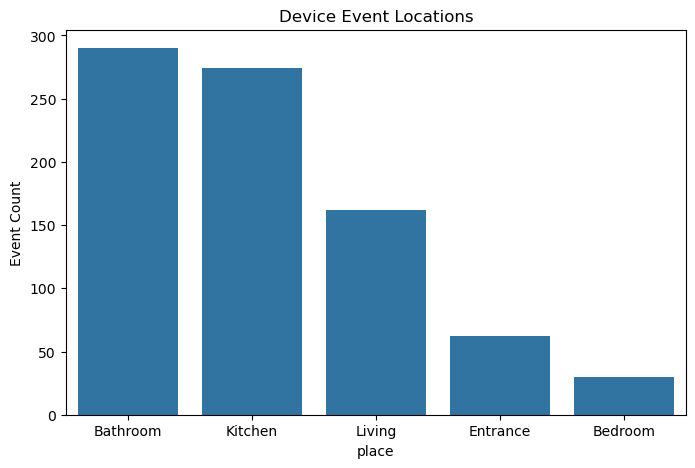

In [10]:
device_location_counts = devices['place'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=device_location_counts.index, y=device_location_counts.values)
plt.title('Device Event Locations')
plt.ylabel('Event Count')
plt.show()